In [1]:
!pip install editdistance
!pip install sentencepiece transformers==4.33 datasets sacremoses sacrebleu  -q
!pip install editdistance

import locale
import pandas as pd
import numpy as np
import re
import sys
import typing as tp
import unicodedata
import gc
import random
import torch
import sacrebleu
import editdistance
from sklearn.model_selection import train_test_split
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig, get_constant_schedule_with_warmup, pipeline
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from sacremoses import MosesPunctNormalizer
from transformers import MarianMTModel, MarianTokenizer
from tqdm import tqdm

pd.options.display.max_colwidth = 100

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
trans_df = pd.read_csv('trans_df.csv')

trans_df.drop(columns = 'Unnamed: 0', inplace = True)
trans_df = trans_df[trans_df.ru.notna()]
print(trans_df.isnull().sum())

print(trans_df.split.value_counts())

df_train = trans_df[trans_df.split=='train'].copy()
df_dev = trans_df[trans_df.split=='dev'].copy()
df_test = trans_df[trans_df.split=='test'].copy()

ru       0
tyv      0
split    0
dtype: int64
split
train    108183
test       5000
dev        4999
Name: count, dtype: int64


In [3]:
additional_sentences_ru = []
additional_sentences_tyv = []

for sentence_tyv, sentence_ru in zip(df_train.tyv, df_train.ru):
  sentence_split = sentence_ru.split(' ')
  if len(sentence_split) > 5:
    additional_sentences_ru.append(sentence_ru)
    additional_sentences_tyv.append(sentence_tyv)

print(len(additional_sentences_ru))
print(len(additional_sentences_tyv))

20700
20700


In [4]:
additional_sentences_ru[0] = 'листья нужно ошпаривать кипятком в течение 5 минут'

In [5]:
model_name_ru_fr = 'Helsinki-NLP/opus-mt-ru-fr'
tokenizer_ru_fr = MarianTokenizer.from_pretrained(model_name_ru_fr)
model_ru_fr = MarianMTModel.from_pretrained(model_name_ru_fr)

# Load the tokenizer and model for French to Russian translation
model_name_fr_ru = 'Helsinki-NLP/opus-mt-fr-ru'
tokenizer_fr_ru = MarianTokenizer.from_pretrained(model_name_fr_ru)
model_fr_ru = MarianMTModel.from_pretrained(model_name_fr_ru)

# Move models to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ru_fr.to(device)
model_fr_ru.to(device)

def translate_and_back(sentences):
    # Tokenize the sentences for Russian to French
    inputs_ru_fr = tokenizer_ru_fr(sentences, return_tensors='pt', padding=True, truncation=True).to(device)

    # Translate from Russian to French
    with torch.no_grad():
        translated_fr = model_ru_fr.generate(**inputs_ru_fr)

    # Decode the French sentences
    french_sentences = [tokenizer_ru_fr.decode(t, skip_special_tokens=True) for t in translated_fr]

    # Tokenize the French sentences for French to Russian
    inputs_fr_ru = tokenizer_fr_ru(french_sentences, return_tensors='pt', padding=True, truncation=True).to(device)

    # Translate from French to Russian
    with torch.no_grad():
        translated_ru = model_fr_ru.generate(**inputs_fr_ru)

    # Decode the Russian sentences
    final_sentences = [tokenizer_fr_ru.decode(t, skip_special_tokens=True) for t in translated_ru]

    return final_sentences

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [117]:
sentences = [additional_sentences_ru[0], additional_sentences_ru[1]]

# Translate and back-translate the sentences
final_sentences = translate_and_back(sentences)

print(final_sentences)

['Листьи должны быть очищены в течение 5 минут.', 'Поэтому вы можете начать учиться помогать другим и служить им.']


In [6]:
additional_sentences_ru_back_translated = [translate_and_back(sentence) for sentence in tqdm(additional_sentences_ru)]

100%|██████████| 20700/20700 [2:47:55<00:00,  2.05it/s]


In [8]:
df_additional = pd.DataFrame(additional_sentences_ru_back_translated, columns = ['ru'])
df_additional['tyv'] = additional_sentences_tyv
df_additional

,ru,tyv
0,Листьи должны быть очищены в течение 5 минут.,савой капустазының бүрүлерин 5 минуттуң дургузунда чымчадыр
1,Поэтому вы можете начать учиться помогать другим и служить им.,Ынчангаш өскелерге дузалап база оларның чаагай чоруу дээш бараан болуп эгелеп шыдаар силер.
2,"После прошлых дней Елизавет, его жена, начала болтать и ехать в течение пяти месяцев.","Элээн үе эрткен соонда, ооң кадайы Елисавета иштели бергеш, оозун беш ай дургузунда өске улустан..."
3,"И вы увидите Сына человека, сидящего на силе человека и направляющегося к облакам небес.",Моон соңгаар силер шупту Кижи амытан Оглунуң Күчүлүг Бурганның оң талазында олурарын база дээрни...
4,Он был профессором и помощником пастора.,ол башкының болгаш хүрээниң удуртукчу башкызының дузалакчызының ажылын күүседип турган
...,...,...
20695,"У семьи Дёрсли было все, что мы могли бы пожелать.","Оглунуң шупту күзээн чүүлдерин хандырып, чаг иштинде бүүрек дег өстүрүп органнар."
20696,"Я сделал то, что вы сказали.",Мен силерниң чугаалааныңар ёзугаар кылдым
20697,"Это осень, но всё же горячо.","күс-даа болза, ам-даа чылыг"
20698,Вы имеете право верить или не верить в изучение Библии.,"Библияның өөредиинге бүзүрээрин, бүзүревезин боттарыңар билир силер."


In [10]:
df_additional.to_csv('paraphrased_trans_df.csv')

from google.colab import files

files.download('paraphrased_trans_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
final_trans_df = pd.concat([df_additional, trans_df], axis = 0)
final_trans_df.reset_index(drop = True, inplace = True)
final_trans_df.fillna('train', inplace = True)
final_trans_df

,ru,tyv,split
0,Листьи должны быть очищены в течение 5 минут.,савой капустазының бүрүлерин 5 минуттуң дургузунда чымчадыр,train
1,Поэтому вы можете начать учиться помогать другим и служить им.,Ынчангаш өскелерге дузалап база оларның чаагай чоруу дээш бараан болуп эгелеп шыдаар силер.,train
2,"После прошлых дней Елизавет, его жена, начала болтать и ехать в течение пяти месяцев.","Элээн үе эрткен соонда, ооң кадайы Елисавета иштели бергеш, оозун беш ай дургузунда өске улустан...",train
3,"И вы увидите Сына человека, сидящего на силе человека и направляющегося к облакам небес.",Моон соңгаар силер шупту Кижи амытан Оглунуң Күчүлүг Бурганның оң талазында олурарын база дээрни...,train
4,Он был профессором и помощником пастора.,ол башкының болгаш хүрээниң удуртукчу башкызының дузалакчызының ажылын күүседип турган,train
...,...,...,...
138877,Черновицкая область,Черновиц можу,dev
138878,физический,күш,train
138879,храбрый баран,дидим кошкар,train
138880,Вы вправе верить или не верить учению Библии.,"Библияның өөредиинге бүзүрээрин, бүзүревезин боттарыңар билир силер.",train


In [14]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [21]:
def word_tokenize(text):
    return re.findall('(\w+|[^\w\s])', text)

texts_with_unk = [text for text in final_trans_df.tyv if tokenizer.unk_token_id in tokenizer(text).input_ids]
print(len(texts_with_unk))

6407


In [16]:
mpn = MosesPunctNormalizer(lang="en")
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [22]:
texts_with_unk_normed = [text for text in texts_with_unk if tokenizer.unk_token_id in tokenizer(preproc(text)).input_ids]
print(len(texts_with_unk_normed))

32


In [19]:
def fix_tokenizer(tokenizer, new_lang='tyv_Cyrl'):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [20]:
fix_tokenizer(tokenizer)

In [23]:
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'tyv_Cyrl', '<mask>'])) # [256202, 256203, 256204]

[256202, 256203, 256204]


In [24]:
added_token_id = tokenizer.convert_tokens_to_ids('tyv_Cyrl')
similar_lang_id = tokenizer.convert_tokens_to_ids('kir_Cyrl')
print(added_token_id, similar_lang_id)

256203 256095


In [25]:
model = AutoModelForSeq2SeqLM.from_pretrained('facebook/nllb-200-distilled-600M')
model.resize_token_embeddings(len(tokenizer))

# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


In [26]:
df_train = final_trans_df[final_trans_df.split=='train'].copy()
df_dev = final_trans_df[final_trans_df.split=='dev'].copy()
df_test = final_trans_df[final_trans_df.split=='test'].copy()

In [37]:
def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

  0%|          | 0/118182 [06:28<?, ?it/s]


In [28]:
model.cuda();

In [38]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [39]:
batch_size = 8  # 32 already doesn't fit well to 15GB of GPU memory
max_length = 128
warmup_steps = 1_000
training_steps = 57000

In [40]:
losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

In [41]:
LANGS = [('ru', 'rus_Cyrl'), ('tyv', 'tyv_Cyrl')]

def get_batch_pairs(batch_size, data=df_train):
    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(preproc(item[l1]))
        yy.append(preproc(item[l2]))
    return xx, yy, long1, long2

print(get_batch_pairs(1))
# (['чеди'], ['семь'], 'tyv_Cyrl', 'rus_Cyrl')

(['Амыдыралыңарны хынамчалыг сайгарып көрүңер.'], ['Тщательно анализируйте свою жизнь.'], 'tyv_Cyrl', 'rus_Cyrl')


In [42]:
model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

  0%|          | 0/57000 [00:00<?, ?it/s]

0 3.1366117000579834
1000 3.6262112798690795
2000 2.8237760759592057
3000 2.5047398521900175
4000 2.324418741822243
5000 2.2005666251182556
6000 2.0873896127045155
7000 2.027278447687626
8000 1.9688522835969926
9000 1.8922372469902038
10000 1.8676257490813732
11000 1.7997244600057603
12000 1.7845350207090378
13000 1.7561063565611839
14000 1.701417284667492
15000 1.6525246150791646
16000 1.626131786108017
17000 1.6376177783608437
18000 1.5787260026931762
19000 1.5652936589121818
20000 1.54176745313406
21000 1.5359044693410397
22000 1.4985012677609921
23000 1.4803659324645997
24000 1.4765393128395081
25000 1.4392170442342758
26000 1.4182337917685508
27000 1.4207319084405898
28000 1.4126310235857964
29000 1.392201964467764
30000 1.356795452773571
31000 1.3414330648183823
32000 1.3569754283726216
33000 1.330353961676359
34000 1.313110484391451
35000 1.3338261473178863
36000 1.2941644128262997
37000 1.2737654349803924
38000 1.2706284413039683
39000 1.2421982955038549
40000 1.223224076658487

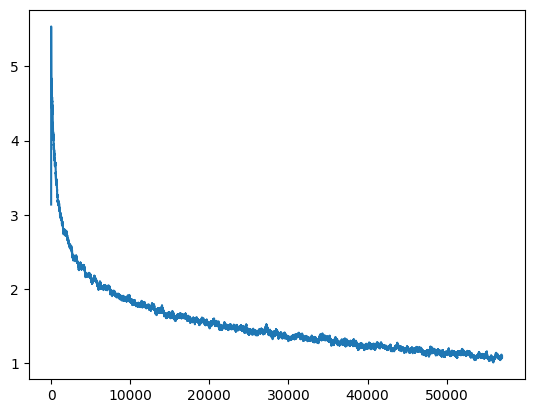

In [44]:
pd.Series(losses).ewm(100).mean().plot();

In [45]:
def translate(text, src_lang='rus_Cyrl', tgt_lang='eng_Latn', a=32, b=3, max_input_length=1024, num_beams=4, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams,
        **kwargs
    )
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [46]:
df_dev['rus_translated'] = [translate(t, 'tyv_Cyrl', 'rus_Cyrl')[0] for t in tqdm(df_dev.tyv)]
df_dev['tyv_translated'] = [translate(t, 'rus_Cyrl', 'tyv_Cyrl')[0] for t in tqdm(df_dev.ru)]

100%|██████████| 4999/4999 [43:16<00:00,  1.93it/s]


In [47]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++

In [48]:
print(bleu_calc.corpus_score(df_dev['rus_translated'].tolist(), [df_dev['ru'].tolist()]))
print(chrf_calc.corpus_score(df_dev['rus_translated'].tolist(), [df_dev['ru'].tolist()]))
print(bleu_calc.corpus_score(df_dev['tyv_translated'].tolist(), [df_dev['tyv'].tolist()]))
print(chrf_calc.corpus_score(df_dev['tyv_translated'].tolist(), [df_dev['tyv'].tolist()]))

BLEU = 15.90 42.9/20.7/11.3/6.4 (BP = 1.000 ratio = 1.021 hyp_len = 23687 ref_len = 23207)
chrF2++ = 40.43
BLEU = 16.75 45.4/22.3/12.1/6.8 (BP = 0.985 ratio = 0.985 hyp_len = 22843 ref_len = 23188)
chrF2++ = 44.56


In [50]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [51]:
upload_repo = "Nacoor/nllb_600_paraphrase"
tokenizer.push_to_hub(upload_repo)
model.push_to_hub(upload_repo)

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Nacoor/nllb_600_paraphrase/commit/45e1d6a9773f313842ecf869cdff368f6131f62d', commit_message='Upload M2M100ForConditionalGeneration', commit_description='', oid='45e1d6a9773f313842ecf869cdff368f6131f62d', pr_url=None, pr_revision=None, pr_num=None)

In [52]:
def translate(
    text,
    model,
    tokenizer,
    src_lang='rus_Cyrl',
    tgt_lang='tyv_Cyrl',
    max_length='auto',
    num_beams=4,
    no_repeat_ngram_size=4,
    n_out=None,
    **kwargs
):
    tokenizer.src_lang = src_lang
    encoded = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    if max_length == 'auto':
        max_length = int(32 + 2.0 * encoded.input_ids.shape[1])
    model.eval()
    generated_tokens = model.generate(
        **encoded.to(model.device),
        forced_bos_token_id=tokenizer.lang_code_to_id[tgt_lang],
        max_length=max_length,
        num_beams=num_beams,
        no_repeat_ngram_size=no_repeat_ngram_size,
        num_return_sequences=n_out or 1,
        **kwargs
    )
    out = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    if isinstance(text, str) and n_out is None:
        return out[0]
    return out

In [53]:
translate("когда моя мама приехала домой, мои друзья уже начали есть", model=model, tokenizer=tokenizer)

'кажан авам бажыңга чедип келгенде, эштерим чип эгеледи'

In [54]:
translate("сколько тебе лет исполнится в следующем году?", model=model, tokenizer=tokenizer)

'дараазында чылын каш харлыг болур сен?'